##  Quality verification software for linear barcodes
### a Computer Vision and Image Processing project 
#### by Enrico Benedetti (enrico.benedetti5@studio.unibo.it)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

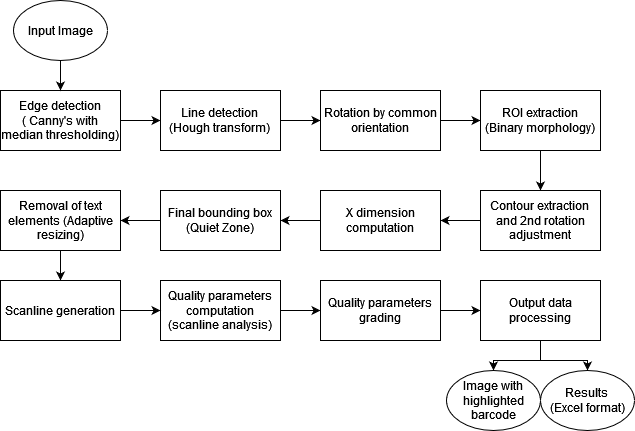

In [2]:
from IPython.display import Image
Image(filename="pictures/project_pipeline.png")

##### Input image

We read the input image. 
- The grayscale version will be used for the barcode recognition and analysis task. 
- The color version will be used later for the output.

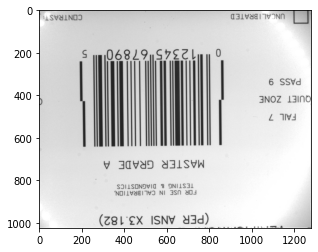

In [3]:
# input image path
img_path = './codici-lineari-dati/UPC#01.BMP'

# get image name (eg 'ABC.XYZ')
img_name = os.path.basename(img_path)
# read the original color image (in the end it will have a green outline where the barcode was found)
img_original = cv2.imread(img_path, cv2.IMREAD_COLOR)
# convert it to grayscale
img = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
# show images
plt.imshow(img_original)
plt.show()

##### Edge detection (Canny's with median thresholding)

The median intensity of pixels in the image is computed to make edge detection more adaptive with respect to lighting changes.

Then, edge detection is performed with Canny's algorithm [as explained in this tutorial](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html).

The result is now the a binarized image with edges.

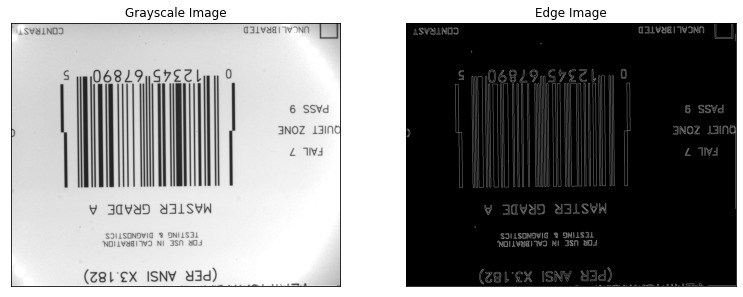

In [4]:
# coefficient for the canny histeresys thresholds
sigma = 0.33
# compute the median of the single channel pixel intensities
median = np.median(img)

# apply Canny's edge detection using the computed median
canny_tlow = int(max(0, (1.0 - sigma) * median))
canny_thigh = int(min(255, (1.0 + sigma) * median))
edges = cv2.Canny(img, canny_tlow, canny_thigh, L2gradient=True)

plt.figure(figsize=(13,13))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

##### Line detection (Hough transform)

In this block the Hough transform (probabilistic algorithm) is used to get a set of lines in the image (in the forms of two endpoints for each line).

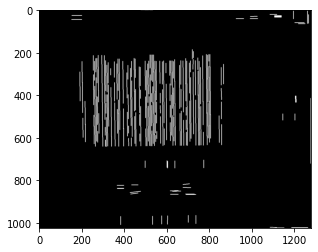

In [5]:
# hough transform parameters
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 1800  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments

lines_edges = np.copy(img) * 0  # creating a blank to draw lines on

# run HoughLinesP on edge detected image
# lines is an output array containing the endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

# computes the orientation and length of the line segments
theta = np.zeros(lines.shape[0])
lengths = np.zeros(lines.shape[0])
i = 0
for line in lines:
    for x1,y1,x2,y2 in line:
        # draw the line
        cv2.line(lines_edges,(x1,y1),(x2,y2),(255,0,0),2)

        #compute the orientation
        theta[i] = -abs(np.arctan2((y2-y1), (x2-x1)))
        lengths[i] = np.sqrt((y2-y1)**2 + (x2-x1)**2)
        i+=1

plt.imshow(lines_edges,cmap = 'gray')
plt.show()

##### Rotation by most common orientation

The found lines will then be filtered based on which orientation is the most prevalent (this can be made more robust, by trying out also a couple of other most common values).

The filtered line segments are then rotated to make them vertical wrt the horizontal axis.

Orientation Histogram

The bin value is increased by one for each line with that orientation. The orientation is selected as a mean between the most prevalent angle and the bin next to it.

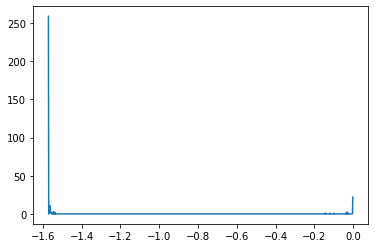

0
-1.5700101424471513


In [6]:
# create bins for the histogram
bins=np.linspace(start=-0.5*np.pi, stop=0, num=1000, endpoint=True)
hist, bins_2 = np.histogram(theta, bins=bins)

plt.plot(bins[:-1], hist)
plt.show()
#sum together the wraparound angles
top_angle_index = np.argmax(hist)
print(top_angle_index)
barcode_angle_rads = (bins[top_angle_index]+bins[top_angle_index+1])/2
#barcode_angle_rads = bins[top_angle_index]

print(barcode_angle_rads)

Filtering by most common orientation

Filtered 36 lines


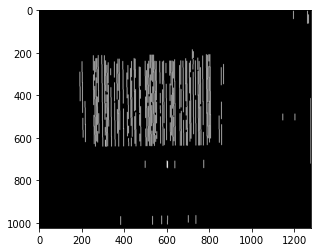

In [7]:
# angle tolerance
tol = np.pi/100
# filtering
lines_filtered = lines[abs(abs(theta) - abs(barcode_angle_rads)) <= tol]
print(f'Filtered {lines.shape[0]- lines_filtered.shape[0]} lines')

lines_edges_filtered = img.copy() * 0
for line in lines_filtered:
    # draw the filtered lines
    for x1,y1,x2,y2 in line:
        cv2.line(lines_edges_filtered,(x1,y1),(x2,y2),(255,0,0),2)


plt.imshow(lines_edges_filtered, cmap='gray')
plt.show()

Rotation to vertically align lines

This is done in order to work better with the binary morphology rectangular structuring elements.

-179.95495495495496


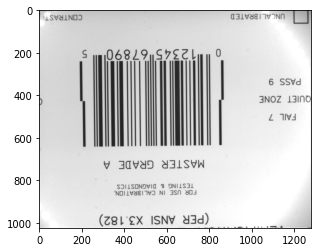

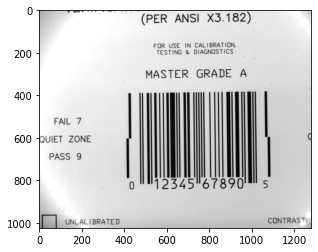

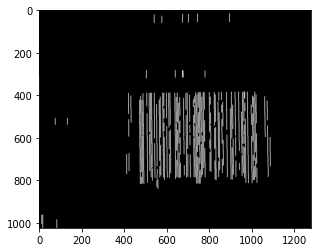

In [8]:
correction_angle = 180*(barcode_angle_rads-np.pi/2)/np.pi # want vertical lines
#correction_angle = np.abs(180*(barcode_angle_rads-np.pi/2)/np.pi) # want vertical lines
print(correction_angle)
plt.imshow(img, cmap='gray')
plt.show()

rows = img.shape[0]
cols = img.shape[1]

img_center = (cols/2, rows/2)
M = cv2.getRotationMatrix2D(img_center, correction_angle, 1)
# rotate grayscale image
img = cv2.warpAffine(img, M, (cols, rows), borderValue=255)
# rotate line edges
lines_edges_filtered = cv2.warpAffine(lines_edges_filtered, M, (cols, rows), borderValue=0)

# re compute edge detection on rotated image
edges = cv2.Canny(img, canny_tlow, canny_thigh, L2gradient=True)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(lines_edges_filtered, cmap='gray')
plt.show()

##### ROI extraction (Binary morphology)

Binary morphology operations of opening and closing are performed on the remaining lines, to fill the space between them and produce a blob ideally representing the barcode region.
The reasoning behind the morphology operations chosen to perform the task is:
- Open in order to preserve long vertical lines
- Close horizontally to form blobs with lines that are close to each other
- Open one last time to remove parts that stick out

Note: pixel values for the structuring element have been determined by manually trying different values that worked for the majority of dataset images. This could probably be automatically computed on an image-per-image basis, for example by considering the positions and distances of white pixels and finding a measure for the kernel from them in some way.

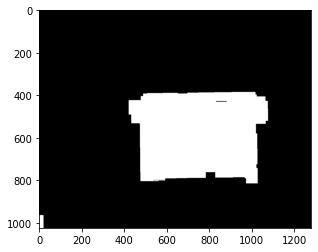

In [9]:
# now we try do get only the big barcode part blob

# make the structuring element of a certain shape
# open then close then open
morph = lines_edges_filtered.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
morph = cv2.morphologyEx(lines_edges_filtered, cv2.MORPH_OPEN, kernel)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 40))
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

plt.imshow(morph, cmap='gray')
plt.show()

##### Contour extraction and 2nd rotation adjustment

We use the opencv function `findContours` to get the shape enclosing the binary morphology blobs.

Then, assuming the biggest blob is the barcode region, we get the minimum enclosing rectangle for it.

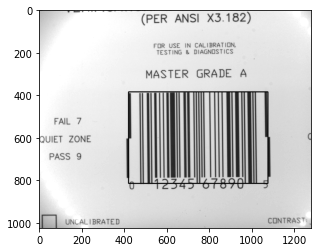

In [10]:
# find the contours in the thresholded image, then sort the contours by their area, keeping only the largest one
(cnts, _) = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
# draw a bounding box arounded the detected barcode and display the image
img_boxed = img.copy()
cv2.drawContours(img_boxed, [box], -1, (0, 0, 0), 3)
plt.imshow(img_boxed, cmap='gray')
plt.show()

We compute the center coordinates and lengths of the bounding box dimension.

In [11]:
# box dimensions
box_center = rect[0][0], rect[0][1]
box_width, box_height = int(np.ceil(rect[1][0])), int(np.ceil(rect[1][1]))
# the angle of the enclosing rectangle (in range [-90,0])
second_correction_angle = rect[2]

# make sure it has longest side horizontal. if necessary swap width and height
if box_width < box_height:

    second_correction_angle = -abs(second_correction_angle - 90.0)
    temp = box_width
    box_width = box_height
    box_height = temp
# angle by which the image has been rotated
rotation_angle = correction_angle + second_correction_angle

A second rotation centered on the barcode is performed to better align it correctly along the horizontal axis.

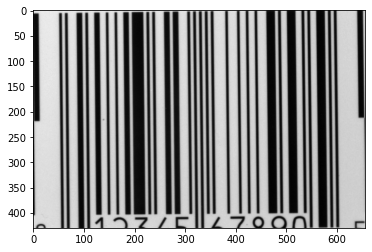

In [12]:
# rotate again the box to make it horizontal
shape = (img.shape[1], img.shape[0])
matrix = cv2.getRotationMatrix2D(center=box_center, angle=second_correction_angle, scale=1)
img = cv2.warpAffine(src=img, M=matrix, dsize=shape)

# crop to get only the horizontal barcode
x_hbox = int(box_center[0] - box_width/2)
y_hbox = int(box_center[1] - box_height/2)
cropped = img[y_hbox:y_hbox + box_height, x_hbox:x_hbox + box_width]

# display the result
plt.imshow(cropped, cmap='gray')
plt.show()

##### X dimension computation

To compute the X dimension, which is the length (in pixels) of the thinnest bar, multiple horizontal scans are performed to be more robust. The scans are performed against the edge image, so that when we encounter an edge we can stop accumulating the current X dimension value.

In [13]:
roi = cropped
_, roi_th = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

roi_edges = cv2.Canny(roi_th, canny_tlow, canny_thigh, L2gradient=True)

# get X dimension (size in px of thinnest bar)
# traverse the edges the smallest space between edges
from statistics import mode
sizey = roi.shape[0]
sizex = roi.shape[1]

# how many times to sample the X dimension
n_samples = 10
# array in which to store the X dimension samples
X_dim_array = np.ones(n_samples, dtype='int') * sizex
# we scan only the middle part of the barcode with horizontal scanlines (text might be in high or low y positions)
scanlines = np.linspace(30*sizey/100, 70*sizey/100, num=n_samples, dtype='int')

for i in range(n_samples):
    X_dim_temp = 0
    for x in range(sizex):
        # if we encounter a bar we keep increasing until its end
        if roi_edges[scanlines[i]][x] == 0:
            X_dim_temp+=1
        else:
            # we reset the count but we keep it if it was smaller the the temporary one
            if X_dim_temp < X_dim_array[i] and X_dim_temp > 1:
                X_dim_array[i] = X_dim_temp
            X_dim_temp=0

print(f'X dimension samples: {X_dim_array}')
print('X_dim = ', mode(X_dim_array))
# take as X dimension the most frequent value (mode)
X_dim = mode(X_dim_array)

X dimension samples: [4 4 4 4 4 4 4 4 4 2]
X_dim =  4


#### Final bounding box (Quiet Zone)

The previous bounding box in theory should not account for the quiet zone (a blank area necessary to facilitate the barcode scanning task), so it is properly enlarged.
Precisely, a padding of 1 X dimension is added to the top and bottom bounding box size, while 10 X dimensions pixels are added to the left and right.

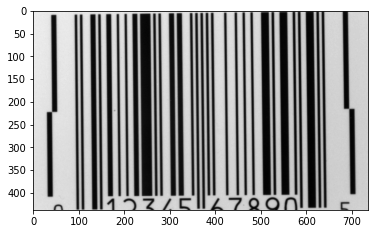

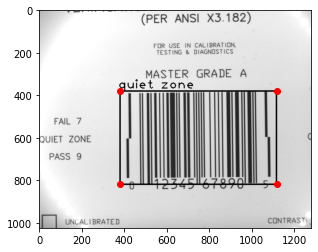

In [14]:
# make sure the quiet zone is properly respected
img_quiet = img.copy()

# resize of image accounting for quiet zone
roi_quiet = img[y_hbox-X_dim:y_hbox + box_height + X_dim, x_hbox-10*X_dim:x_hbox + box_width+10*X_dim]

plt.imshow(roi_quiet, cmap='gray')
plt.show()
# to get all coordinates of bounding box, the points are in this order
### pt1 pt3
### pt4 pt2
pt1=(x_hbox-10*X_dim, y_hbox-X_dim)
pt2=(x_hbox+box_width+10*X_dim, y_hbox+box_height+X_dim)
pt3=(pt2[0], pt1[1])
pt4=(pt1[0], pt2[1])

# show the quiet zone bounding box
text_point = pt1[0]-10, pt1[1]-10 # text coordinates
cv2.rectangle(img_quiet,pt1=pt1, pt2=pt2, color=(0,0,0), thickness=5)
cv2.putText(img_quiet,"quiet zone", text_point, fontFace=cv2.FONT_HERSHEY_PLAIN ,fontScale=4, color=0, thickness=4)
plt.imshow(img_quiet, cmap='gray')
plt.scatter(pt1[0],pt1[1], color='red')
plt.scatter(pt2[0],pt2[1], color='red')
plt.scatter(pt3[0],pt3[1], color='red')
plt.scatter(pt4[0],pt4[1], color='red')
plt.show()

#### Removal of text elements (Adaptive resizing)

Assuming text and other symbols could be present either at the top or bottom of the barcode, they are removed by:
- detecting blobs in the edge image
- bounding those blobs with a rectangle
- setting the barcode height as the minimum height of rectangles that are greater than at least half the roi height. In case there are none, the height is left unchanged
- resizing the image, deleting top or bottom of the image where is present the majority of rectangles with an height smaller than half the barcode region height. (I found that alphanumerical symbols were detected and deleted effectively in this way)

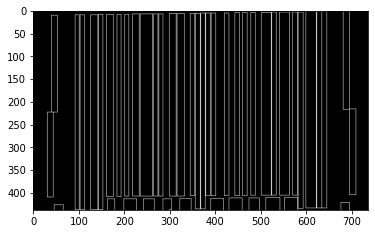

Roi height is 438
Roi width is 736
Cutting the lower region
Resized barcode height is 398


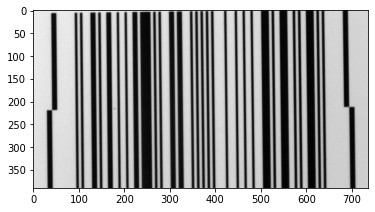

In [15]:
# threshold the quiet zone image
_, roi_th = cv2.threshold(roi_quiet, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# and perform edge detection
roi_edges = cv2.Canny(roi_th, canny_tlow, canny_thigh, L2gradient=True)

# remove text
# ignore quiet zone
contours, hierarchy = cv2.findContours(cv2.bitwise_not(roi_th), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

roi_with_blobs = roi_th.copy()*0
# get rectangles from blobs
blobs_map = map(lambda c: cv2.boundingRect(c), contours)
blobs = np.array(list(blobs_map))

# draw the rectangles (for testing purposes)
for blob in blobs:
    x,y,w,h = blob
    cv2.rectangle(roi_with_blobs, (x, y), (x + w, y + h), (255,255,255), 1)

plt.imshow(roi_with_blobs, cmap='gray')
plt.show()

roi_height = roi_th.shape[0]
roi_width = roi_th.shape[1]

print('Roi height is', roi_height)
print('Roi width is', roi_width)
blobs_heights = blobs[:,3]
blobs_y = blobs[:,1]

try:
    barcode_height = np.min(blobs_heights[blobs_heights > roi_height/2])
except: barcode_height = roi_height

# if the majority of small contours are in lower side, cut from the top, else cut from the bottom
text_upper = blobs_y[(blobs_y < barcode_height //2) & (blobs_heights < barcode_height //2)] # contains small blobs
text_upper_count = text_upper.shape[0]

if text_upper_count > 0:
    # cut upper part
    print('Cutting the upper region')
    cutoff_start = roi_height - barcode_height + X_dim
    cutoff_end = roi_height - X_dim
else:
    # cut lower part
    print('Cutting the lower region')
    cutoff_start = 0 + X_dim
    cutoff_end = barcode_height - X_dim
# resize
roi_small = roi_quiet[cutoff_start:cutoff_end, :]
print('Resized barcode height is', barcode_height)
plt.imshow(roi_small, cmap='gray')
plt.show()

##### Scanline generation


A Scan Reflectance Profile is a record of the reflectance values (0% to 100%) measured along a single line across the entire width of the bar code.

The function below computes those reflectance values from the resized barcode roi, by appending the reflectance values along the horizontal direction, at multiple heights.

In [16]:
# scan reflectance profile
def scan_reflectance(img, n_lines=10, verbose=1, maxval=255):
    '''Computes the scan reflectance profile of n_lines scanlines from an image.
    Verbose=0 > no print, Verbose=1 > plot of scanlines on img, Verbose=2 > plot of also the scan ref. profiles.'''
    # get img h and w
    height, width = img.shape
    # space between scanlines
    alfa = np.uint8(height / (n_lines+1))
    for i in range(n_lines):
        # sequence of reflectance values from left to right
        reflectance = []
        if i == 0:
            for j in range(width):
                reflectance.append((img[alfa*(i+1)][j]/maxval)*100)
            ref = reflectance
        else:
            for j in range(width):
                reflectance.append((img[alfa*(i+1)][j]/maxval)*100)
            # stack on one another
            ref = np.vstack([ref, reflectance])

    # optionally plot the scanlines
    if verbose == 1:
        plt.imshow(img, cmap='gray')
        for i in range(n_lines):
            plt.hlines(alfa*(i+1),xmin=0, xmax=width, colors='red')
        plt.show()
    # optionally plot the scan reflectance profiles
    if verbose == 2:
        for i in range(n_lines):
            print('Scan Reflectance Profile of line', i+1, ':')
            plt.plot(ref[i])
            plt.show()
    return ref

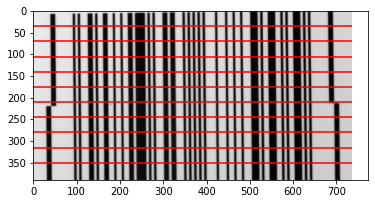

In [17]:
# compute reflectance profiles
reflectance_profiles = scan_reflectance(roi_small, n_lines=10, verbose=1)

##### Quality parameters computation (scanline analysis)

The function below measures, given a scan reflectance profile, the required quality parameters. A brief summary is in the following table. For more information, consult the ANSI document.

| Quality Parameter              | Description |
|--------------------------------|-------------|
| $R_{min}$                          | The minimum reflectance |
| $R_{max}$                           | The maximum reflectance        |
| Symbol Contrast (SC)           | Symbol Contrast is the difference between the highest reflectance value and the lowest reflectance value anywhere in the scan reflectance profile, including the quiet zones       |
| Global Threshold (GT)          | A global Threshold  is established on the scan reflectance profile by drawing a horizontal line half way between the highest reflectance value and the lowest reflectance value seen in the profile         |
| Number of edges                | The number of crossings of the Global Threshold            |
| Minimum Edge Constrast ($EC_{min}$) | It is determined as the difference between the peak values of adjacent elements (spaces and bars). The edge that has the smallest change between adjacent elements gives the value for the Minimum Edge Contrast          |
| Modulation                     | Modulation is defined as the ratio between Minimum Edge Contrast and Symbol Contrast. It measures how well element of different widths can be read by a scanner            |
| Element Reflectance non-uniformity ($ERN$)          |  Element Reflectance non-uniformity is the difference between the highest reflectance value and the lowest reflectance value found within a given element           |
| Defects                        | Defects are voids found in bars or spots found in the spaces and quiet zones of the code, and show as an irregularity in the reflectance profile of the bar or space. Each element is individually evaluated for its reflectance non-uniformity. Dividing the maximum $ERN$ for the barcode by Symbol Contrast gives the measure for Defects.           |



In [18]:
# function that computes the quality parameters for a scanline
def quality_scan(reflectance, verbose=False):
    '''Takes the reflectance profile and returns the values for all parameters, in a dictionary.
    (min reflectance, min edge contrast, symbol contrast, modulation, defects, number of edges). Also returns the sequence of lenghts of bars and spaces.'''
    # edge determination = number of crossings of the global threshold. 
    # Gt = (min + max)/2 = Rmin + SC/2
    # SC = (max-min)/2
    Rmin = np.min(reflectance)
    Rmax = np.max(reflectance)
    s_contrast = Rmax - Rmin
    glob_th = Rmin + (s_contrast/2)
    
    # divides reflectance values into numerated spaces and bars
    xs = range(0, len(reflectance))
    n_edges = 0
    # list containing the sequences of reflectance values for spaces
    space_v = []
    # list containing the sequences of reflectance values for bars
    bar_v = []
    # list containing the current sequence
    curr_v = []
    # list containing the pixel length of each element
    dimension_sequence = []
    is_space = True
    for i in xs:
        if is_space and reflectance[i] >= glob_th:
            #continue appending space values
            curr_v.append(reflectance[i])
        elif is_space and reflectance[i] < glob_th:
            #switch to bar values
            space_v.append(curr_v)
            dimension_sequence.append(len(curr_v))
            curr_v = []
            is_space = False
            n_edges+=1
            curr_v.append(reflectance[i])
        elif not(is_space) and reflectance[i] < glob_th:
            #continue appending bar values
            curr_v.append(reflectance[i])
        elif not(is_space) and reflectance[i] >= glob_th:
            # switch to spaces
            bar_v.append(curr_v)
            dimension_sequence.append(len(curr_v))
            curr_v = []
            is_space = True
            n_edges+=1
            curr_v.append(reflectance[i])
    #append last (assumed quiet zone)
    space_v.append(curr_v)
    dimension_sequence.append(len(curr_v))
    n_edges-=1

    # ec min computation. uses max instead of min and viceversa because it gives results more in line to the wanted ones
    ec_min = 100
    plot_ecmin_xs = (0,0)
    for i in range(len(bar_v)):
        if space_v[i] == [] or bar_v[i] == [] or space_v[i+1] ==[]:
            continue
        #adjacent elements
        Rs_min = max(space_v[i])
        Rb_max = min(bar_v[i])
        ec = Rs_min - Rb_max
        if ec < ec_min:
            ec_min = ec
            #print('worst partial ec min= {:2.2f} - {:2.2f} = {:2.2f}'.format(Rs_min,Rb_max, ec_min))
            plot_ecmin_ys = (Rs_min,Rb_max) #to plot where they are from
        #also a bar and the following element
        Rs_min = max(space_v[i+1])
        Rb_max = min(bar_v[i])
        ec = Rs_min - Rb_max
        if ec < ec_min:
            ec_min = ec
            #print('worst partial ec min= {:2.2f} - {:2.2f} = {:2.2f}'.format(Rs_min,Rb_max, ec_min))
            plot_ecmin_ys = (Rs_min,Rb_max)

    # modulation
    modulation = ec_min/s_contrast

    #element reflectance non uniformity: max - min of values in an element
    ern_max = 0
    # considering those too close to the edge skews the results too much towards F grade
    try:
        for i in range(len(bar_v)):
            ern = np.max(bar_v[i][2:-2]) - np.min(bar_v[i])
            if ern > ern_max:
                ern_max = ern
        for i in range(len(space_v)):
            ern = np.max(space_v[i]) - np.min(space_v[i][2:-2])
            if ern > ern_max:
                ern_max = ern
    except: pass
    # defects = ern_max/symbol contrast
    defects = ern_max/s_contrast

    # make return dictionary
    quality_parameters = {'Rmin': Rmin, 'Rmax': Rmax, 'SC': s_contrast, 'ECmin': ec_min,
     'MOD':modulation, 'Defects':defects, 'Number of edges':n_edges}

    # optional plots and prints
    if verbose == True:
        print('global threshold =', glob_th)
        for k in quality_parameters:
            print(k, '=', quality_parameters[k])
        plt.plot(reflectance)
        plt.xlabel('x')
        plt.ylabel('reflectance') 
        plt.ylim(0,100)
        plt.grid()
        plt.scatter(x=[x for x in range(0,len(reflectance))],s=3,y=reflectance, color='black')
        plt.hlines(Rmin, xmin=0,xmax=len(reflectance), colors='blue')
        plt.hlines(Rmax, xmin=0,xmax=len(reflectance), colors='green')
        plt.hlines(glob_th, xmin=0,xmax=len(reflectance), colors='red')
        plt.hlines(y=plot_ecmin_ys, xmin=0,xmax=len(reflectance), colors='purple')
        plt.show()

    return quality_parameters, dimension_sequence

##### Quality parameters grading

The function computes two dictionaries of pairings `parameter: grades` for the required quality parameters. One contains alphabetical grades, the other numerical.
The gradings are performed following the specifications of "The Layman's Guide to ANSI, CEN, and ISO Bar Code Print Quality Documents".

In [19]:
# function that computes the quality parameters grades from a dict of values 
def compute_grades(quality_parameters, verbose=False):
    '''Takes the dictionary of quality parameters and returns the grades as letters and numbers as a tuple of dictionaries.
    The computation is based on the specifications in the barcode quality guide.
    keys:(min reflectance, min edge contrast, symbol contrast, modulation, defects)'''
    # use function variables to be concise
    Rmin = quality_parameters['Rmin']
    Rmax = quality_parameters['Rmax']
    SC = quality_parameters['SC']
    ECmin = quality_parameters['ECmin']
    MOD = quality_parameters['MOD']
    Defects = quality_parameters['Defects']
    # create grade dictionary
    grades = {'Rmin': None, 'SC': None, 'ECmin': None, 'MOD':None, 'Defects':None}

    # Rmin
    if Rmin <= 0.5 * Rmax:
        grades['Rmin'] = 'A'
    else: grades['Rmin'] = 'F'
    # ECmin
    if ECmin >= 15:
        grades['ECmin'] = 'A'
    else: grades['ECmin'] = 'F'
    # symbol contrast
    if SC >= 70:
        grades['SC'] = 'A'
    elif SC >= 55:
        grades['SC'] = 'B'
    elif SC >= 40:
        grades['SC'] = 'C'
    elif SC >= 20:
        grades['SC'] = 'D'
    else:
        grades['SC'] = 'F'
    # modulation
    if MOD >= 0.70:
        grades['MOD'] = 'A'
    elif MOD >= 0.60:
        grades['MOD'] = 'B'
    elif MOD >= 0.50:
        grades['MOD'] = 'C'
    elif MOD >= 0.40:
        grades['MOD'] = 'D'
    else:
        grades['MOD'] = 'F'
    # defects
    if Defects <= 0.15:
        grades['Defects'] = 'A'
    elif Defects <= 0.20:
        grades['Defects'] = 'B'
    elif Defects <= 0.25:
        grades['Defects'] = 'C'
    elif Defects <= 0.30:
        grades['Defects'] = 'D'
    else:
        grades['Defects'] = 'F'

    # convert to numerical grades in another dict
    grades_num = grades.copy()
    for k in grades_num:
        if grades[k] == 'F':
            grades_num[k] = 0
        else:
            # ascii trick for everything except F
            grades_num[k] = ord('E') - ord(grades_num[k])
    return grades, grades_num

Cycling over scanlines

For each scanline, the following actions are performed:
- computation of quality parameters and barcode dimensions
- grading

Finally, to give the barcode its final grade, the mean (taking into account each scanline's worst grade) is computed, according to the ANSI document specifications.

In [20]:
def process_reflectance_profiles(reflectance_profiles):
    # create a dictionary to collect all results
    scanline_data = dict()
    # counter for the scanline number
    scanline_number = 1
    # list of scanline grades
    scanline_grades = []
    # for each reflectance profile
    for ref in reflectance_profiles:
        # get the quality parameters and the sequence of bars/spaces dimensions
        quality_parameters, dimension_sequence = quality_scan(ref, verbose=False)
        # get grades
        grades, grades_num = compute_grades(quality_parameters)
        # add the lowest grade of the scanline to the list
        scanline_grades.append(min(*grades_num.values()))
        # add data to dictionary
        scanline_data[scanline_number] = {'Scanline number' : scanline_number, 'Sequence of bars and space dimensions (Xdim units)' : dimension_sequence//X_dim}
        # reorganize structure for excel output
        for key in quality_parameters.keys():
            scanline_data[scanline_number][key] = quality_parameters[key]
        for key in grades.keys():
            scanline_data[scanline_number][key+' grade'] = grades[key]
        scanline_number+=1

    # compute barcode grade as mean of all the scanlines grades
    barcode_grade_num = np.mean(scanline_grades)
    # convert it to a symbol
    if barcode_grade_num >= 3.5:
        barcode_grade_symbol = 'A'
    elif barcode_grade_num >= 2.5:
        barcode_grade_symbol = 'B'
    elif barcode_grade_num >= 1.5:
        barcode_grade_symbol = 'C'
    elif barcode_grade_num >= 0.5:
        barcode_grade_symbol = 'D'
    else:
        barcode_grade_symbol = 'F'

    return scanline_data, barcode_grade_num, barcode_grade_symbol

In [21]:
scanline_data, barcode_grade_num, barcode_grade_symbol = process_reflectance_profiles(reflectance_profiles)
print(f'Barcode grade: {barcode_grade_num}/{barcode_grade_symbol}')

Barcode grade: 4.0/A


##### Output data processing

The code below outputs the original image with the highlighted barcode box drawn onto it.

To do that, the bounding box is transformed by the rotation matrix with angle opposite to the first rotation, around the original image center.

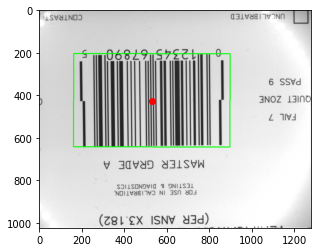

In [22]:
# get matrix of opposite rotation
matrix_inverse = cv2.getRotationMatrix2D(center=img_center, angle=-correction_angle, scale=1)
# to perform the affine transformation, homogenous coordinates are needed
boxcenter_omogenous = np.vstack([box_center[0], box_center[1], 1])
# rotation * center
center_original = np.dot(matrix_inverse, boxcenter_omogenous)
# get back the rectangle with the original image position and rotation
original_rect = ((int(center_original[0]), int(center_original[1])), (int(box_width+20*X_dim), int(box_height+2*X_dim)), rotation_angle)
# as well as the bounding box for the original image
original_bb = np.int0(cv2.boxPoints(original_rect))
# draw a green box around the barcode in the original image
cv2.drawContours(img_original,[original_bb],0,(0,255,0),thickness=3)

# save the image to the results folder
cv2.imwrite(f'./results/out_{img_name}', cv2.cvtColor(img_original, cv2.COLOR_RGB2BGR)) 
# plot output with red center
plt.imshow(img_original, cmap='gray')
plt.scatter(center_original[0],center_original[1], color='red')
plt.show()

To produce an Excel file, the data dictionary is exported into xlsx worksheets using the `pandas` library.

In [23]:
import pandas as pd

# create dataframes using the required data
df1 = pd.DataFrame([{'Image name': img_name, 'Overall grade': f'{barcode_grade_num}/{barcode_grade_symbol}', 'X dimension': X_dim, 'Barcode height': roi_height, 'Vertexes of b. box': original_bb, 
    'Box center' : np.int0(center_original), 'Angle(deg)': rotation_angle }])
df2 = pd.DataFrame.from_dict(scanline_data, orient='index')

# create a Pandas Excel writer using XlsxWriter as the engine, and define the output filename
writer = pd.ExcelWriter(f'./results/excel_{img_name}.xlsx')

# write each dataframe to a different worksheet
df1.to_excel(writer, sheet_name='Barcode parameters', index=False)
df2.to_excel(writer, sheet_name='Scanline parameters', index=False)

# save and close the writer and output the Excel file
writer.save()
#writer.close()

##### Barcode quality verification and Gaussian Noise

The effect of Gaussian noise is studied plotting the change in the quality parameters when 0-mean ($\mu$), varying standard deviation ($\sigma$) noise is added to the barcode region.

In [24]:
# from the dataframe, given a parameter name, get its mean value along the scanlines
def get_mean_from_scanline_dataframe(df, par):
    values = []
    for scanline_number in df.columns:
        values.append(df[scanline_number][par])
    return np.mean(values)

In [25]:
from skimage.util import random_noise

params_to_study = ['Rmin', 'SC', 'ECmin', 'MOD', 'Defects', 'Number of edges']
noise_roi = roi_small.copy()

#noise_roi = random_noise(image=noise_roi, mode='gaussian', seed=42, mean=0, var=0.2)
#plt.imshow(noise_roi, cmap='gray')
#plt.show()

# standard deviation values
noise_sigmas = np.linspace(start=0, stop=0.2, num=100, endpoint=True)
# results container
noise_results = pd.DataFrame(columns = params_to_study, index=noise_sigmas)
for noise_sigma in noise_sigmas:
    # reset the image
    noise_roi = roi_small.copy()
    # it produces images in range [0,1] but that's ok for reflectance
    noise_roi = random_noise(image=noise_roi, mode='gaussian', seed=42, mean=0, var=(noise_sigma)**2)
    # compute quality parameters from reflectance profiles
    reflectance_profiles = scan_reflectance(noise_roi, n_lines=10, verbose=0, maxval=1)
    scanline_data, barcode_grade_num, barcode_grade_symbol = process_reflectance_profiles(reflectance_profiles)
    noise_df = pd.DataFrame(scanline_data)
    # for all parameters we want to study we get the value across scanlines
    for par in params_to_study:
        noise_results[par][noise_sigma] = get_mean_from_scanline_dataframe(noise_df, par)

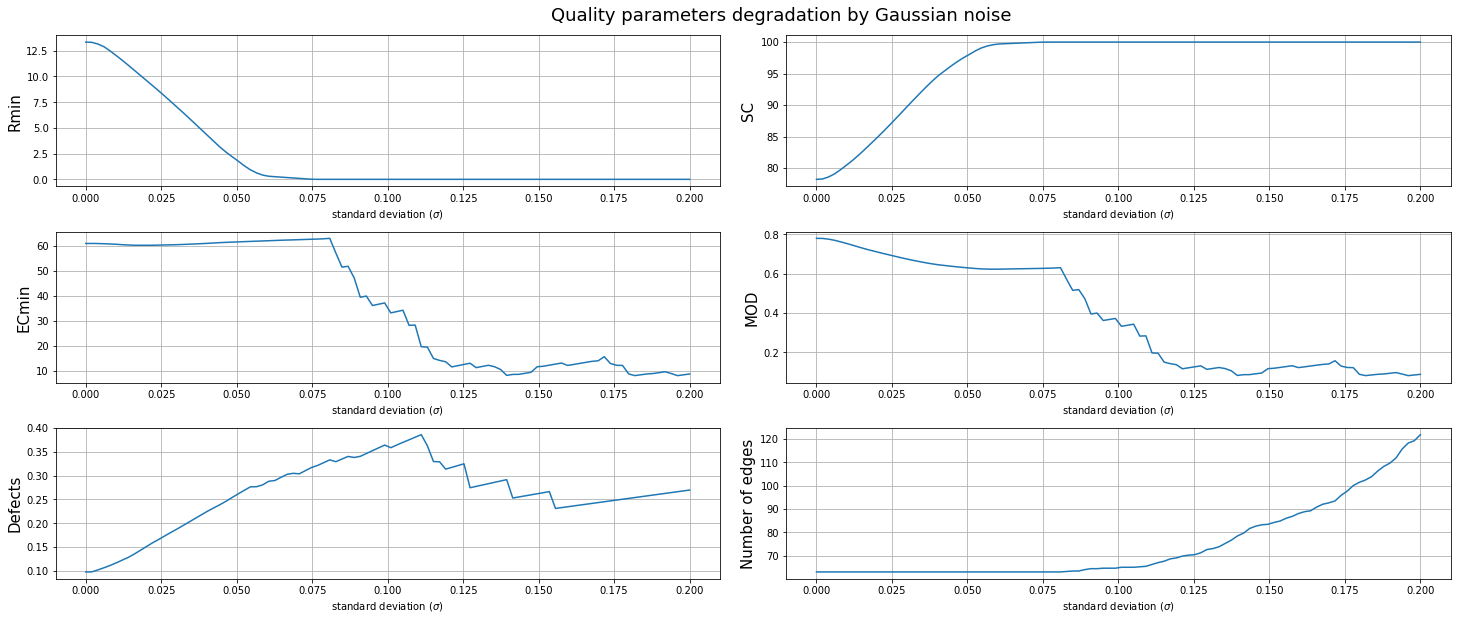

In [26]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(25,10)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.text(x=0.4, y=0.9, s='Quality parameters degradation by Gaussian noise', fontsize=18)
i = 0
for par in params_to_study:
    axs[i//2][i%2].plot(noise_sigmas, noise_results[par])
    axs[i//2][i%2].set_xlabel('standard deviation $(\sigma)$', fontsize=10)
    axs[i//2][i%2].set_ylabel(par, fontsize=15)
    axs[i//2][i%2].grid()
    i+=1
plt.show()

Gaussian noise added to the image worsens the scanning process, with most of the parameters getting a lower grade. The standard deviation for the experiments increased linearly in the range $[0,0.2]$ (we can consider this a percentage-wise $\sigma$, because the `skimage` function for adding random noise works with images in $[0,1]$).
An important thing to note is that from $0.075$ onwards, the barcode is virtually impossible to read, because the number of edges starts to change considerably.
- $R_{min}$ goes from its normal value to $0%$ due to the noise. $R_{max}$ should reach $100%$ instead.
- $SC$ increases up to $100%$, in accordance to its dependence from the maximum and minimum reflectance values.
- $EC_{min}$ stays consistent up to a threshold, then starts to fall.
- Modulation as well.
- Defects increase due to noise, then the rest is supposedly random because the bars and spaces are not really consistent anymore.